In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error
%matplotlib inline 

In [3]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

# MLL and Scikit Results

In [15]:
path = '~/sims_n_results/simupdates_aug2020/'
learn_path = 'learn29/rand_err/tset0.1_'
csv_end = '_nuc29_random_error.csv'
burn_knn = pd.read_csv(path + learn_path + 'burnup_knn' + csv_end).drop(columns='Unnamed: 0')
burn_dtr = pd.read_csv(path + learn_path + 'burnup_dtree' + csv_end).drop(columns='Unnamed: 0')
rxtr_knn = pd.read_csv(path + learn_path + 'reactor_knn' + csv_end).drop(columns='Unnamed: 0')
rxtr_dtr = pd.read_csv(path + learn_path + 'reactor_dtree' + csv_end).drop(columns='Unnamed: 0')
enri_knn = pd.read_csv(path + learn_path + 'enrichment_knn' + csv_end).drop(columns='Unnamed: 0')
enri_dtr = pd.read_csv(path + learn_path + 'enrichment_dtree' + csv_end).drop(columns='Unnamed: 0')
cool_knn = pd.read_csv(path + learn_path + 'cooling_knn' + csv_end).drop(columns='Unnamed: 0')
cool_dtr = pd.read_csv(path + learn_path + 'cooling_dtree' + csv_end).drop(columns='Unnamed: 0')

In [35]:
cool_dtr.head(1)

,Percent Error,DTree Score,DTree Std
0,0.0,0.996243,0.00013


In [21]:
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
mll = {}
for i, unc_job in enumerate(job_dirs):
    mll['unc' + str(i)] = pd.read_csv(path + 'train29/' + unc_job + '/' + unc_job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll.keys()

dict_keys(['unc0', 'unc1', 'unc2', 'unc3'])

In [23]:
mll['unc1'].head(1)

,sim_idx,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,AvgPowerDensity,ModDensity,UiWeight,pred_idx,...,CDF_LLUnc_0.5,CDF_LogLL_0.1,CDF_LLUnc_0.1,CDF_LogLL_0.01,CDF_LLUnc_0.01,ReactorType_Score,CoolingTime_Error,Enrichment_Error,Burnup_Error,OrigenReactor_Score
0,21,bwr,1875.921048,0.5,965.63,ge7x7-0,10.0,0.56,1,22,...,50.98308,-76522.156344,46.156809,-5.891514e+07,35.712602,True,15.938932,0.0,0.0,True


In [24]:
mll['unc1'].columns

Index(['sim_idx', 'ReactorType', 'CoolingTime', 'Enrichment', 'Burnup',
       'OrigenReactor', 'AvgPowerDensity', 'ModDensity', 'UiWeight',
       'pred_idx', 'pred_ReactorType', 'pred_CoolingTime', 'pred_Enrichment',
       'pred_Burnup', 'pred_OrigenReactor', 'AvgPowerDensity.1',
       'ModDensity.1', 'UiWeight.1', 'MaxLogLL', 'MaxLLUnc', '2ndMaxLogLL',
       '2ndMaxLLUnc', 'CDF_LogLL_0.9998', 'CDF_LLUnc_0.9998',
       'CDF_LogLL_0.9988', 'CDF_LLUnc_0.9988', 'CDF_LogLL_0.95',
       'CDF_LLUnc_0.95', 'CDF_LogLL_0.9', 'CDF_LLUnc_0.9', 'CDF_LogLL_0.5',
       'CDF_LLUnc_0.5', 'CDF_LogLL_0.1', 'CDF_LLUnc_0.1', 'CDF_LogLL_0.01',
       'CDF_LLUnc_0.01', 'ReactorType_Score', 'CoolingTime_Error',
       'Enrichment_Error', 'Burnup_Error', 'OrigenReactor_Score'],
      dtype='object')

# Processing MLL Results

In [95]:
def score(error, y_true):
    zero_cnt = len(y_true) - np.count_nonzero(y_true)
    if zero_cnt > 0:
        error, y_true = zip(*((e, y) for e, y in zip(error, y_true) if y != 0))
        error = np.array(error)
        y_true = np.array(y_true)
    return 1 - np.mean(error / y_true)

In [26]:
rxtr_mll = []
burn_mll = []
enri_mll = []
cool_mll = []
for i, unc_job in enumerate(uncs):
    rxtr_mll.append(accuracy_score(mll['unc'+str(i)]['ReactorType'], mll['unc'+str(i)]['pred_ReactorType']))
    burn_mll.append(explained_variance_score(mll['unc'+str(i)]['Burnup'], mll['unc'+str(i)]['pred_Burnup']))
    enri_mll.append(explained_variance_score(mll['unc'+str(i)]['Enrichment'], mll['unc'+str(i)]['pred_Enrichment']))
    cool_mll.append(explained_variance_score(mll['unc'+str(i)]['CoolingTime'], mll['unc'+str(i)]['pred_CoolingTime']))

In [29]:
burn_mll

[0.9997063502841064, 0.9996524943866792, 0.999548294663721, 0.9990392283109104]

# Plotting

In [36]:
def plot_errorcurves(title): 
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)   
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Percent Error', fontsize=20, labelpad=15)
    ax.set_ylabel('Score', fontsize=20, labelpad=15)
    
    unc = [100*x for x in uncs]
    sv_base = '../plots/randomerror_compare_'
    if 'Reactor' in title:
        knn_mean = rxtr_knn['kNN Score']
        knn_std = rxtr_knn['kNN Std']
        dtr_mean = rxtr_dtr['DTree Score']
        dtr_std = rxtr_dtr['DTree Std']
        mll = rxtr_mll
        sv_fig = sv_base + 'rxtr.png'
    elif 'Burnup' in title:
        knn_mean = burn_knn['kNN Score']
        knn_std = burn_knn['kNN Std']
        dtr_mean = burn_dtr['DTree Score']
        dtr_std = burn_dtr['DTree Std']
        mll = burn_mll
        sv_fig = sv_base + 'burn.png'
    elif 'Enrichment' in title:
        knn_mean = enri_knn['kNN Score']
        knn_std = enri_knn['kNN Std']
        dtr_mean = enri_dtr['DTree Score']
        dtr_std = enri_dtr['DTree Std']
        mll = enri_mll
        sv_fig = sv_base + 'enri.png'
    else:
        knn_mean = cool_knn['kNN Score']
        knn_std = cool_knn['kNN Std']
        dtr_mean = cool_dtr['DTree Score']
        dtr_std = cool_dtr['DTree Std']
        mll = cool_mll
        sv_fig = sv_base + 'cool.png'
    
    #Scikit Results
    err = burn_knn['Percent Error']
    ax.fill_between(err, knn_mean - knn_std, knn_mean + knn_std, color = colors['MBrwn'], alpha=0.2)
    ax.fill_between(err, dtr_mean - dtr_std, dtr_mean + dtr_std, color = colors['MTeal'], alpha=0.2)
    ax.plot(err, knn_mean, 'o-', color=colors['MBrwn'], mew=0, ms=5, label="kNN")
    ax.plot(err, dtr_mean, 'o-', color=colors['MTeal'], mew=0, ms=5, label="Decision Tree")
    
    # MLL Results
    ax.plot(unc, mll, 'o-', color=colors['MPurp'], mew=0, ms=5, label="MLL Calc")
    
    ax.tick_params(labelsize=14)
    ax.legend(loc='best')#'right', bbox_to_anchor=(1.4, 0.5))
    plt.show()
    
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

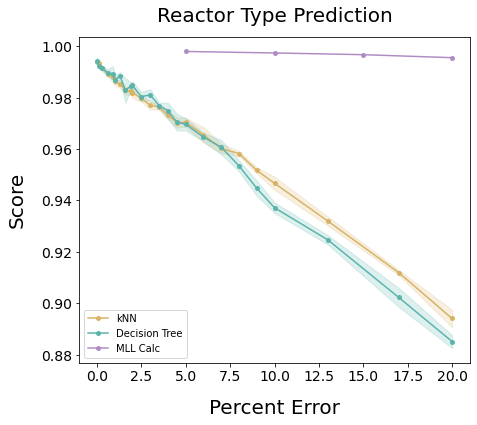

In [37]:
plot_errorcurves('Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

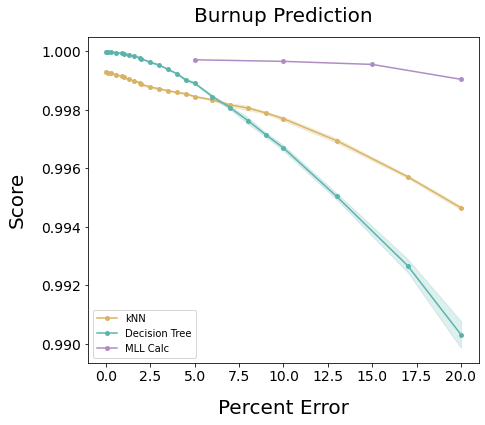

In [38]:
plot_errorcurves('Burnup Prediction')

<Figure size 432x288 with 0 Axes>

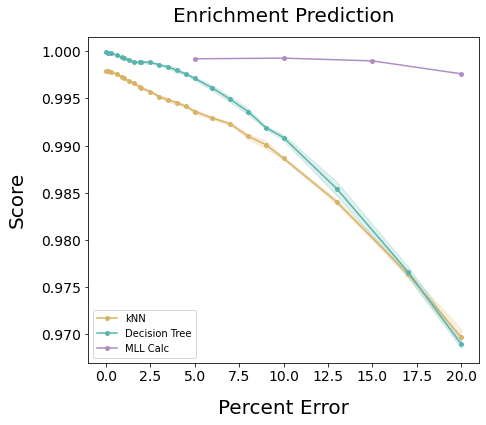

In [39]:
plot_errorcurves('Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

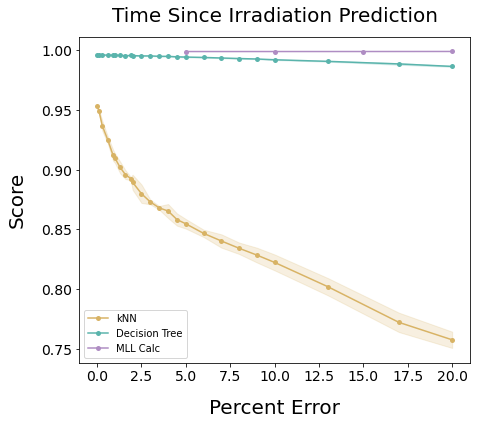

In [40]:
plot_errorcurves('Time Since Irradiation Prediction')